In [1]:
with open('./share/common.py') as fin:
   exec(fin.read())

In [2]:
with open('./share/matplotlibconf.py') as fin:
    exec(fin.read())

## Title: understand how descriptions are related with points

In [3]:
### import packages for ML 
import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
### import cleaned dataset
data_file = "Output/wine_cleaned.csv"
df = pd.read_csv(data_file)

### Check the size of data from 'description' and 'points'

In [5]:
df.count()

country                  129908
description              129908
points                   129908
price                    120916
province                 129908
region_1                 108724
taster_name              103664
taster_twitter_handle     98695
title                    129908
variety                  129907
winery                   129908
Wine_Year                129908
dtype: int64

### Remove data rows with duplicated description, empty description and empty points.  A large number of descriptions are duplicated.  

In [6]:
df[df.duplicated(subset=None, keep='first')].count()

country                  9979
description              9979
points                   9979
price                    9378
province                 9979
region_1                 8296
taster_name              8652
taster_twitter_handle    8212
title                    9979
variety                  9979
winery                   9979
Wine_Year                9979
dtype: int64

In [7]:
df_parsed = df[df.duplicated('description', keep=False)]
df_parsed.dropna(subset=['description', 'points'])
df_parsed.count()

country                  20018
description              20018
points                   20018
price                    18806
province                 20018
region_1                 16648
taster_name              17354
taster_twitter_handle    16474
title                    20018
variety                  20018
winery                   20018
Wine_Year                20018
dtype: int64

#### Grouped by 'points' column, and check the distribution of 'description' over 'points'.  There are 17 unique points distributed with descriptions.

In [8]:
df_sub = df_parsed[['description', 'points']]
df_sub.groupby(['points']).count()

,description
points,
81,6
82,46
83,124
84,513
85,931
...,...
93,644
94,266
95,44


### Plot the distribution of 17 different points values

In [9]:
data = df_sub.groupby(['points']).count()['description'].reset_index()

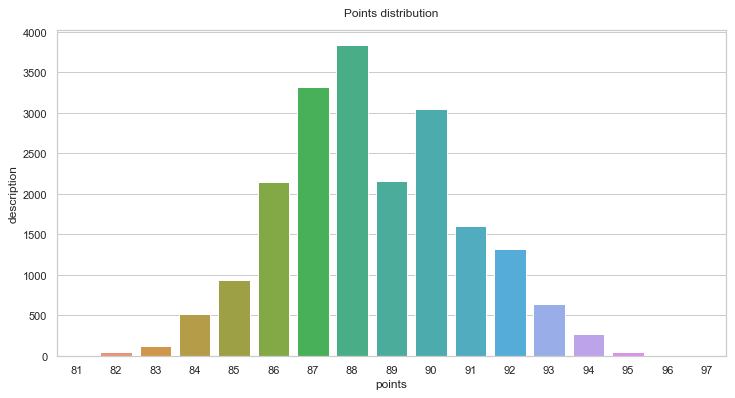

In [10]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")
ax = sns.barplot(x='points', y='description', data=data)
ax.set_title("Points distribution")
ax.figure.savefig('./img_ca/fig_01.png')

### Description length vs Points

In [11]:
df_sub = df_sub.assign(description_len = df_sub['description'].apply(len))

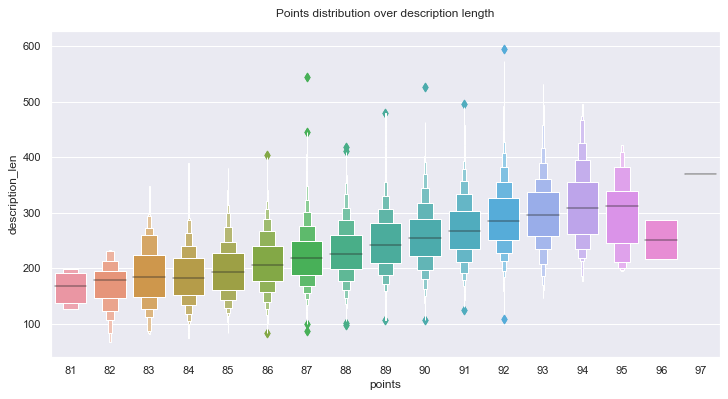

In [12]:
plt.figure(figsize=(12,6))
ax = sns.set(color_codes=True)
ax = sns.boxenplot(x='points', y='description_len', data=df_sub)
ax.set_title('Points distribution over description length')
ax.figure.savefig('./img_ca/fig_02.png')

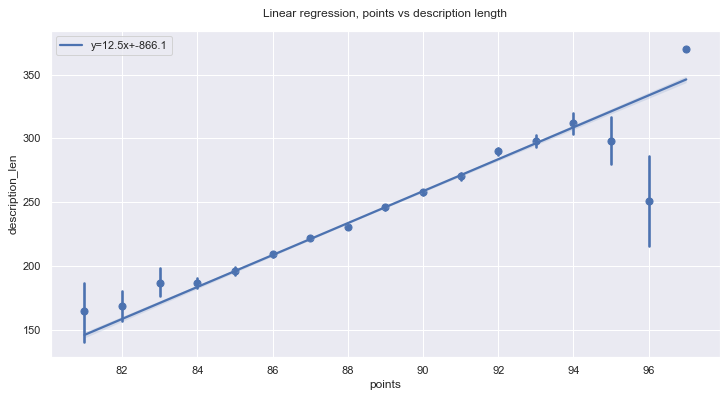

In [13]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sub['points'], df_sub['description_len'])
plt.figure(figsize=(12,6))
sns.set(color_codes=True)
ax = sns.regplot(x='points', y='description_len', data=df_sub,  x_estimator=np.mean, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title('Linear regression, points vs description length')
ax.legend()
ax.figure.savefig('./img_ca/fig_03.png')

#### There are wide variance of discription length at lower and upper side of points.  

#### 5 different bins.  This is also a set up for clustering points into 5 different categories.

In [14]:
bins = [0, 84, 86, 88, 90, 100]
labels = [1, 2, 3, 4, 5]
df_sub['points_binned'] = pd.cut(df_sub['points'], bins=bins, labels=labels)
df_sub['points_binned'].value_counts()

3    7154
4    5203
5    3888
2    3084
1     689
Name: points_binned, dtype: int64

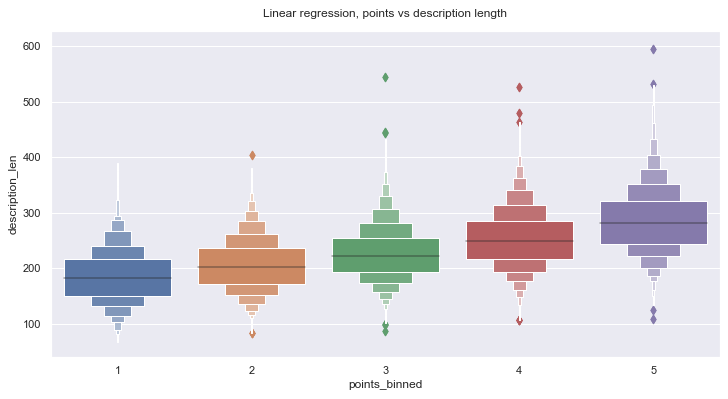

In [15]:
plt.figure(figsize=(12,6))
sns.set(color_codes=True)
ax = sns.boxenplot(x='points_binned', y='description_len', data=df_sub)
ax.set_title('Linear regression, points vs description length')
ax.figure.savefig('./img_ca/fig_04.png')

#### The above plot looks much better.  As we distribute points into 5 separate bins, linear regression is much easier.   

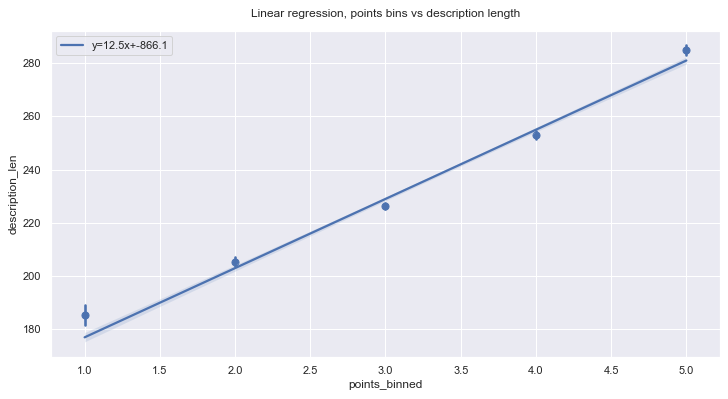

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sub['points'], df_sub['description_len'])

plt.figure(figsize=(12,6))
sns.set(color_codes=True)
ax = sns.regplot(x='points_binned', y='description_len', x_estimator=np.mean, data=df_sub, color='b', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
ax.set_title('Linear regression, points bins vs description length')
ax.figure.savefig('./img_ca/fig_05.png')

### Prediction of points using description
#### Two steps process 
#### 1. TfidfVectorizer - Transforms text to feature vectors that can be used as input to estimator.
#### 2. Random Forest -The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree

#### X: input data [bag of words, i.e. description],  y: classification [1,2,3,4,5]
#### Transform test to feature vectors

In [17]:
X = df_sub['description']
y = df_sub['points_binned']
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

#### Split train and test data set.  10% of data is used for test. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Run predictions using test data set.  The accuracy is over 95% (not bad at all..)

In [19]:
predictions = rfc_model.predict(X_test)

In [20]:
target_names = ['Score 1', 'Score 2', 'Score 3', 'Score 4', 'Score 5']
print(classification_report(y_test, predictions, target_names=target_names, digits=4))

precision    recall  f1-score   support

     Score 1     1.0000    0.8571    0.9231        70
     Score 2     0.9861    0.9071    0.9449       312
     Score 3     0.9249    0.9801    0.9517       704
     Score 4     0.9648    0.9610    0.9629       513
     Score 5     0.9749    0.9628    0.9688       403

    accuracy                         0.9560      2002
   macro avg     0.9701    0.9336    0.9503      2002
weighted avg     0.9573    0.9560    0.9560      2002



#### Save tfidf vectorizer and rfc model 

In [21]:
joblib.dump(rfc_model, './models/rfc_model.pkl', compress=3)


['./models/rfc_model.pkl']

In [22]:
joblib.dump(vectorizer, "./models/vectorizer.pkl", compress=3)

['./models/vectorizer.pkl']

#### Test to make sure stored models work as expected. 
#### 1. Import models

In [23]:
rfc_model = joblib.load('./models/rfc_model.pkl')
vectorizer = joblib.load('./models/vectorizer.pkl')

#### 2. Test using sample description.  We know this is Score 5. 

In [24]:
story = ["Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar."]

In [25]:
story = vectorizer.transform(story)

In [26]:
prediction = rfc_model.predict(story)

In [27]:
prediction[0]

5

### Conclusion
#### We can correlate the length of descriptions with points by testers.  For high and low side of scores, it doesn't show linearity as we didn't have enough data for both low and high side of points.   
#### The next approach was using TFIDF and RandomForestClassifier to predict points using 'description' as a bag of words.   Pretty accurately predict the score base on the description provided.  However, there were many datasets with duplicated descriptions which we couldn't use as valid data as they also don't score the same points.   Apparently, the same descriptions were reused for some number of wines with different titles.   